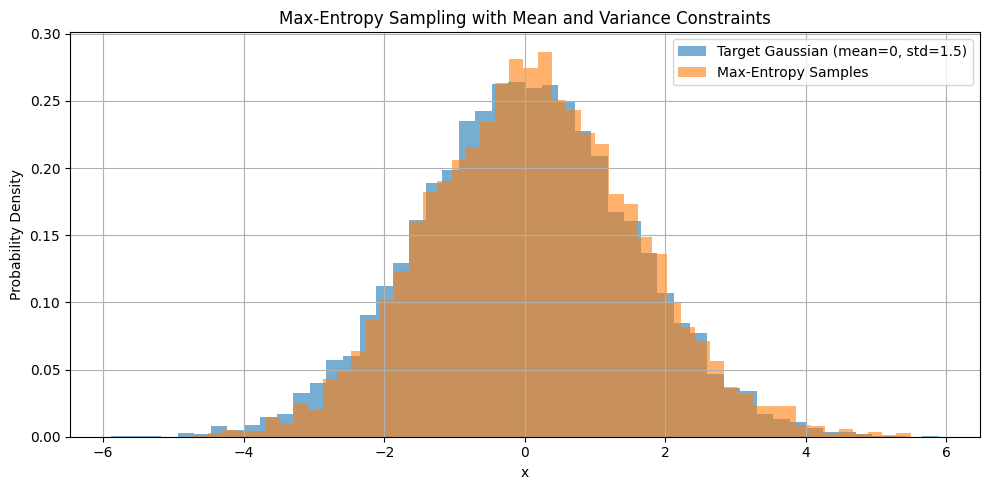

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Goal: generate 1D field samples that match a target histogram (mean and variance)
np.random.seed(42)

# Step 1: Define the target distribution (e.g., Gaussian with specific mean and variance)
target_mean = 0.0
target_std = 1.5
target_distribution = lambda size: np.random.normal(loc=target_mean, scale=target_std, size=size)

# Step 2: Maximum entropy under constraints: assume P(x) ~ exp(-lambda1 * x - lambda2 * x^2)
# This corresponds to matching mean and variance (i.e., max entropy under known first two moments)

# Step 3: Sample from this using Metropolis-Hastings
def metropolis_sampler(num_samples, lambda1, lambda2, proposal_width=1.0):
    samples = [0.0]  # start from 0
    for _ in range(num_samples - 1):
        current = samples[-1]
        proposal = np.random.normal(current, proposal_width)
        
        # Log-probability under max-entropy distribution
        log_p_current = -lambda1 * current - lambda2 * current**2
        log_p_proposal = -lambda1 * proposal - lambda2 * proposal**2
        
        # Metropolis acceptance
        if np.log(np.random.rand()) < log_p_proposal - log_p_current:
            samples.append(proposal)
        else:
            samples.append(current)
    return np.array(samples)

# Set lambda parameters to match mean=0, std=1.5 approximately (empirically tuned)
lambda1 = 0.0
lambda2 = 1 / (2 * target_std**2)

# Generate samples
num_samples = 10000
samples_target = target_distribution(num_samples)
samples_me = metropolis_sampler(num_samples, lambda1, lambda2)

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(samples_target, bins=50, density=True, alpha=0.6, label="Target Gaussian (mean=0, std=1.5)")
plt.hist(samples_me, bins=50, density=True, alpha=0.6, label="Max-Entropy Samples")
plt.legend()
plt.title("Max-Entropy Sampling with Mean and Variance Constraints")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.grid(True)
plt.tight_layout()
plt.show()


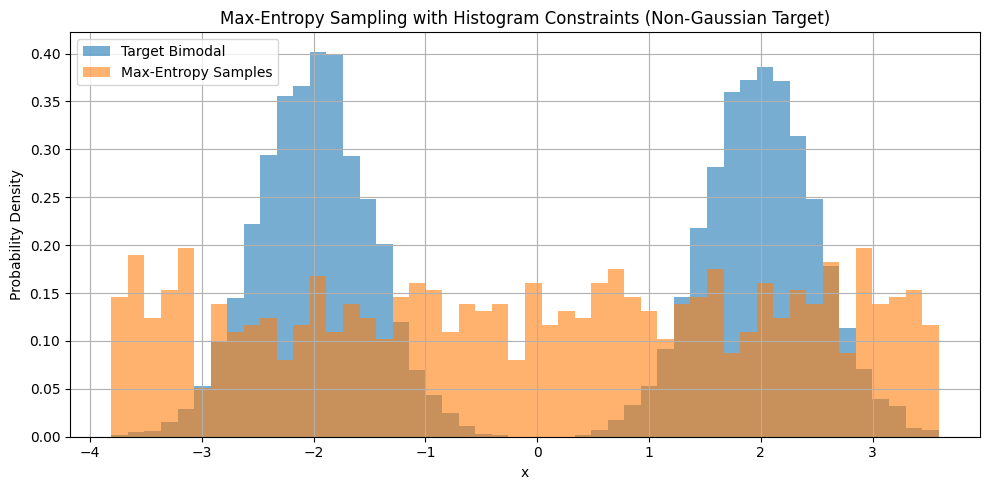

In [2]:
# Generate a non-Gaussian target distribution (e.g., a bimodal mixture of Gaussians)
def bimodal_distribution(size):
    mix = np.random.rand(size)
    # 50% samples from N(-2, 0.5), 50% from N(2, 0.5)
    samples = np.where(mix < 0.5,
                       np.random.normal(loc=-2, scale=0.5, size=size),
                       np.random.normal(loc=2, scale=0.5, size=size))
    return samples

# Histogram matching is harder now — max entropy with just mean/variance won't work.
# So we'll use an empirical histogram as constraints and do MCMC with histogram matching.

# Step 1: Compute target histogram
num_samples = 10000
samples_target = bimodal_distribution(num_samples)
hist_target, bin_edges = np.histogram(samples_target, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 2: Define histogram constraint function
def histogram_energy(x, hist_target, bin_edges):
    hist_x, _ = np.histogram(x, bins=bin_edges, density=True)
    return np.sum((hist_x - hist_target)**2)

# Step 3: Metropolis sampler with histogram-matching energy
def histogram_matching_sampler(num_samples, hist_target, bin_edges, proposal_width=1.0):
    x = np.random.normal(0, 1, num_samples)  # initial state
    energy_current = histogram_energy(x, hist_target, bin_edges)
    
    for _ in range(1000):  # number of MCMC steps
        proposal = x + np.random.normal(0, proposal_width, size=num_samples)
        energy_proposal = histogram_energy(proposal, hist_target, bin_edges)
        
        # Accept if energy decreases or with probability exp(-ΔE)
        if np.random.rand() < np.exp(-(energy_proposal - energy_current)):
            x = proposal
            energy_current = energy_proposal
    return x

# Generate max-entropy samples under histogram constraint
samples_me = histogram_matching_sampler(num_samples, hist_target, bin_edges)

# Plot results
plt.figure(figsize=(10, 5))
plt.hist(samples_target, bins=bin_edges, density=True, alpha=0.6, label="Target Bimodal")
plt.hist(samples_me, bins=bin_edges, density=True, alpha=0.6, label="Max-Entropy Samples")
plt.legend()
plt.title("Max-Entropy Sampling with Histogram Constraints (Non-Gaussian Target)")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.grid(True)
plt.tight_layout()
plt.show()


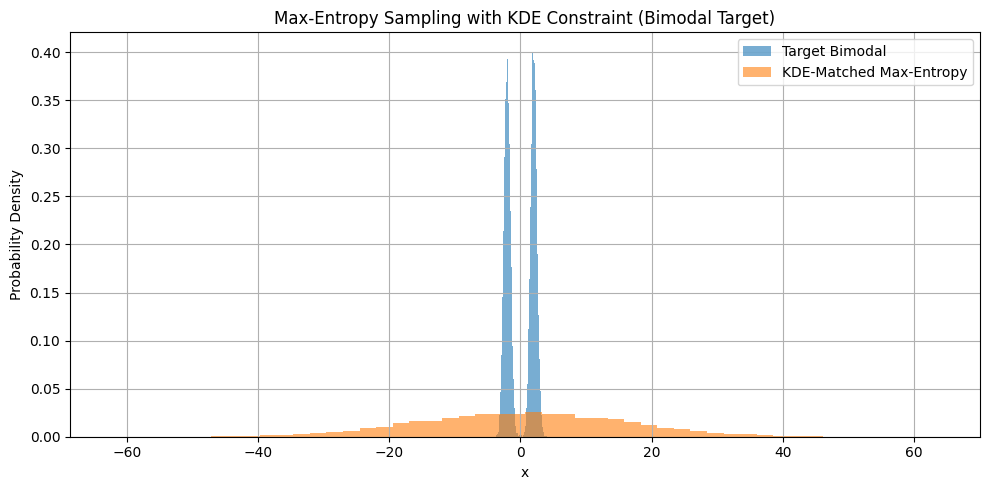

In [3]:
from scipy.stats import gaussian_kde

# Step 1: Generate the target bimodal distribution
def bimodal_distribution(size):
    mix = np.random.rand(size)
    samples = np.where(mix < 0.5,
                       np.random.normal(loc=-2, scale=0.5, size=size),
                       np.random.normal(loc=2, scale=0.5, size=size))
    return samples

# Target samples and KDE
num_samples = 10000
samples_target = bimodal_distribution(num_samples)
kde_target = gaussian_kde(samples_target)

# Step 2: Define KDE-based energy function
def kde_energy(x, kde_target, xs):
    kde_x = gaussian_kde(x)
    return np.sum((kde_x(xs) - kde_target(xs))**2)

# Step 3: Metropolis sampler using KDE energy
def kde_matching_sampler(num_samples, kde_target, xs, proposal_width=0.5, steps=1000):
    x = np.random.normal(0, 1, num_samples)  # initial guess
    energy_current = kde_energy(x, kde_target, xs)

    for _ in range(steps):
        proposal = x + np.random.normal(0, proposal_width, size=num_samples)
        energy_proposal = kde_energy(proposal, kde_target, xs)

        # Metropolis step
        if np.random.rand() < np.exp(-(energy_proposal - energy_current)):
            x = proposal
            energy_current = energy_proposal
    return x

# Define evaluation grid
xs = np.linspace(-4, 4, 200)

# Sample using the improved KDE-based method
samples_kde = kde_matching_sampler(num_samples, kde_target, xs)

# Plot results
plt.figure(figsize=(10, 5))
plt.hist(samples_target, bins=50, density=True, alpha=0.6, label="Target Bimodal")
plt.hist(samples_kde, bins=50, density=True, alpha=0.6, label="KDE-Matched Max-Entropy")
plt.legend()
plt.title("Max-Entropy Sampling with KDE Constraint (Bimodal Target)")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.grid(True)
plt.tight_layout()
plt.show()
